In [323]:
from math import sqrt

import os
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import shap
import plotly.express as px

# For shap to work with keras, disable v2 behavior
tf.compat.v1.disable_v2_behavior()

In [324]:
loc = './stats/'
MODEL_DIR = './models/'

In [337]:
X = pd.read_csv(loc + 'X.csv')
y = pd.read_csv(loc + 'y.csv')

# y = y[['PLAYER_PPG', 'PLAYER_APG', 'PLAYER_3PG']]
y = y['PLAYER_PTS']

# Baseline Models

## PP100 Model

A basic model that predicts the offensive player's points per 100 possessions will be their average points per 100 possessions

In [338]:
X_base = X.copy()
y_base = y.copy()

# X_base['OFF_3PM'] = X_base['OFF_FG3A'] * X_base['OFF_FG3_PCT']
# y_pred = X_base[['OFF_PTS', 'OFF_AST', 'OFF_3PM']].to_numpy()
y_pred = X_base['OFF_PTS_PER_100'].to_numpy()
y_base = y_base.to_numpy()

rmse = np.sqrt(np.mean((y_pred - y_base) ** 2))
mae = mean_absolute_error(y_base, y_pred)
print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 12.601546181525663
MAE: 9.930743926580968


## Average Model

Takes the average of all players, and guesses that any one player's points is equal to that value

In [339]:
X_base = X.copy()
y_base = y.copy()

X_base = X_base['OFF_PTS_PER_100'].to_numpy()
y_base = y_base.to_numpy()

y_pred = [np.average(X_base)] * X_base.size

rmse = np.sqrt(np.mean((y_pred - y_base) ** 2))
mae = mean_absolute_error(y_base, y_pred)
print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 11.052101659013829
MAE: 8.798407903414153


## Linear Regression Model

In [674]:
from sklearn.linear_model import LinearRegression

X_base = X.copy()
X_base.drop(columns=['OFF_POST_TOUCH_PTS', 'OFF_POST_TOUCH_FG_PCT', 'OFF_PTS_PER_100'], inplace=True)
y_base = y.copy()

X_base = X_base.to_numpy()
y_base = y_base.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.2)

model = LinearRegression().fit(X=X_train, y=y_train)
y_pred = model.predict(X_test)

print('RMSE:', np.sqrt(np.mean((y_pred - y_test) ** 2)))
print('MAE:', mean_absolute_error(y_pred, y_test))

# model = LinearRegression().fit(X=X_base, y=y_base)
# y_pred = model.predict(X_base)

# print('RMSE:', np.sqrt(np.mean((y_pred - y_base) ** 2)))
# print('MAE:', mean_absolute_error(y_pred, y_base))

RMSE: 10.811490515629481
MAE: 8.54693328310359


# Sequential Model

Creates a simple Keras model composed of single stack layers connected sequentially.

In [341]:
# Apply normalization to input
X = (X - X.mean()) / X.std()

# Remove points from input dataset
X_seq = X.copy()
X_seq.drop(columns=['OFF_POST_TOUCH_PTS', 'OFF_POST_TOUCH_FG_PCT', 'OFF_PTS_PER_100'], inplace=True)
# X_seq = X_seq[['OFF_MIN', 'OFF_FGA', 'DEF_BLK', 'DEF_D_FG_PCT', 'OFF_PLAYER_HEIGHT_INCHES', 'DEF_PLAYER_HEIGHT_INCHES']]

# Sort columns alphabetically
X_seq = X_seq.sort_index(axis=1)

# Generate training and verification data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2)

print('Training Entries')
X_train.info()
X_train.describe()

print('Testing Entries')
X_test.info()
X_test.describe()

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_seq.columns

Training Entries
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10761 entries, 2886 to 8609
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DEF_AGE                   10761 non-null  float64
 1   DEF_BLK                   10761 non-null  float64
 2   DEF_BOXOUTS               10761 non-null  float64
 3   DEF_CHARGES_DRAWN         10761 non-null  float64
 4   DEF_CONTESTED_SHOTS       10761 non-null  float64
 5   DEF_CONTESTED_SHOTS_3PT   10761 non-null  float64
 6   DEF_DEF_WS                10761 non-null  float64
 7   DEF_DREB                  10761 non-null  float64
 8   DEF_DREB_PCT              10761 non-null  float64
 9   DEF_D_FGA                 10761 non-null  float64
 10  DEF_D_FG_PCT              10761 non-null  float64
 11  DEF_GP                    10761 non-null  float64
 12  DEF_L                     10761 non-null  float64
 13  DEF_MIN                   10761 non-null  

Index(['DEF_AGE', 'DEF_BLK', 'DEF_BOXOUTS', 'DEF_CHARGES_DRAWN',
       'DEF_CONTESTED_SHOTS', 'DEF_CONTESTED_SHOTS_3PT', 'DEF_DEF_WS',
       'DEF_DREB', 'DEF_DREB_PCT', 'DEF_D_FGA', 'DEF_D_FG_PCT', 'DEF_GP',
       'DEF_L', 'DEF_MIN', 'DEF_NORMAL_FG_PCT', 'DEF_PCT_BLK',
       'DEF_PCT_BOX_OUTS_REB', 'DEF_PCT_STL', 'DEF_PLAYER_HEIGHT_INCHES',
       'DEF_PLAYER_WEIGHT', 'DEF_RATING', 'DEF_STL', 'DEF_W', 'OFF_AGE',
       'OFF_AST', 'OFF_BLKA', 'OFF_CATCH_SHOOT_FG_PCT', 'OFF_CATCH_SHOOT_PTS',
       'OFF_DRIVE_FG_PCT', 'OFF_DRIVE_PTS', 'OFF_ELBOW_TOUCH_FG_PCT',
       'OFF_ELBOW_TOUCH_PTS', 'OFF_FG3A', 'OFF_FG3_PCT', 'OFF_FGA',
       'OFF_FG_PCT', 'OFF_FTA', 'OFF_FT_PCT', 'OFF_GP', 'OFF_MIN',
       'OFF_PAINT_TOUCHES', 'OFF_PAINT_TOUCH_FG_PCT', 'OFF_PF',
       'OFF_PLAYER_HEIGHT_INCHES', 'OFF_PLAYER_WEIGHT', 'OFF_PULL_UP_FG_PCT',
       'OFF_PULL_UP_PTS', 'OFF_REB', 'OFF_TOV', 'SEASON_ID'],
      dtype='object')

In [639]:
outsize = 0
try:
    outsize = y.shape[1]
except:
    outsize = 1

# Create model
model = Sequential()
model.add(Dense(25, activation='relu', input_shape=(X_seq.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(54, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(outsize, activation='relu'))

# Compile model
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mse', 'mae'])
model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_311 (Dense)           (None, 25)                1275      
                                                                 
 dropout_168 (Dropout)       (None, 25)                0         
                                                                 
 dense_312 (Dense)           (None, 54)                1404      
                                                                 
 dropout_169 (Dropout)       (None, 54)                0         
                                                                 
 dense_313 (Dense)           (None, 32)                1760      
                                                                 
 dropout_170 (Dropout)       (None, 32)                0         
                                                                 
 dense_314 (Dense)           (None, 1)               

In [640]:
# Set batch size
bsize = int(X_train.shape[0] * 0.6)

# Fit model
%time history = model.fit(X_train, y_train, epochs=3000, validation_split=0.2, batch_size=bsize, verbose=0)

Wall time: 1min 38s


In [641]:
y_pred = model.predict(X_test)

# Evaluate error
score, mse, mae = model.evaluate(X_test, y_test)
print('RMSE:', sqrt(mse))
print('MAE:', mae)

diff = abs(y_pred - y_test)

RMSE: 10.843105505883393
MAE: 8.449484


In [642]:
# Plot training and validation loss
fig = px.line()
fig.add_scatter(y=history.history['loss'], name='Train')
fig.add_scatter(y=history.history['val_loss'], name='Validation')

fig.update_layout(title='Train vs Validation Loss',
                   xaxis_title='Epochs',
                   yaxis_title='Loss')

fig.show()

In [643]:
fig = px.histogram(y_pred, nbins=70)
fig.show()
print(np.std(y_pred))

3.3498318


In [423]:
fig = px.histogram(y_test)
fig.show()
print(np.std(y_test))

10.829489973324938


In [13]:
# compute SHAP values
explainer = shap.DeepExplainer(model, X_train[0:1000])
shap_values = explainer.shap_values(X_test)

# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_seq.columns)

C:\Users\Darrick\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:91: UserWarning:

keras is no longer supported, please use tf.keras instead.

C:\Users\Darrick\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py:96: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



PLAYER_PTS


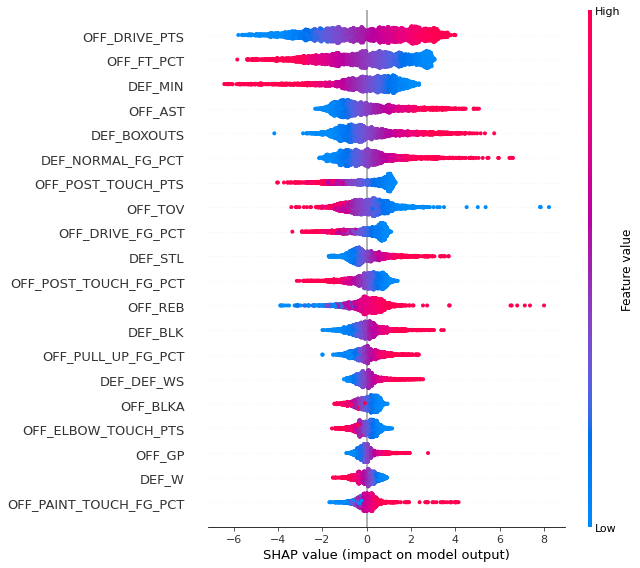

In [14]:
for i in range(0, outsize):
    try:
        print(y.columns[i])
    except:
        print(y.name)
    shap.summary_plot(shap_values[i], X_test, feature_names=X.columns)

In [14]:
import tensorflowjs as tfjs

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

name = input('Set model name: ')
model.save(MODEL_DIR + name + '_keras')
tfjs.converters.save_keras_model(model, MODEL_DIR + name + '_js')

In [204]:
!pip uninstall tensorflow

^C
